In [18]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv('4_new_features1.csv')

In [119]:
df.head()

,Unnamed: 0,Unnamed: 0.1,item name,Время чтения,Сложность,Количество просмотров,В закладках,Комментарии,Автор,Рейтинг автора,Время публикации,Savings_per_Views,norm_ReadingTime,hour
0,0,0,Мультяшная графика продаётся лучше реалистично...,8,2,324.0,1,1,@Kallist,0.0,2023-05-13 19:20:00,0.003086,0.084337,19
1,1,1,Picture in Picture Mode в android. Показываем ...,5,1,122.0,3,0,@cookie2727,0.0,2023-05-13 18:55:00,0.024590,0.048193,18
2,2,2,"Много нас, а GPU один. Как делиться?",6,1,1600.0,5,6,@Antra,6.1,2023-05-13 17:57:00,0.003125,0.060241,17
3,3,3,Ближайшие бесплатные мероприятия по разработке...,2,1,376.0,1,0,@ITMeeting,-0.8,2023-05-13 16:27:00,0.002660,0.012048,16
4,4,4,Одноплатник Orange Pi 5 Plus: характеристики и...,4,",",3500.0,6,13,@Seleditor,49.0,2023-05-13 12:55:00,0.001714,0.036145,12


### Проверка гипотез 1.1

Мы хотим узнать, есть ли разница в ожидаемом количестве сохранений у постов в зависимости от сложности. Визуализация наводила на мысль, что 1 и 2 сложность не отличаются по количеству сохранений. Поэтому мы сравним сначала их, а потом проведем сравнение с 3 сложностью.

In [30]:
easy = df.loc[(df['Сложность'] == '1')]['В закладках'].values
medium = df.loc[(df['Сложность'] == '2')]['В закладках'].values
hard = df.loc[(df['Сложность'] == '3')]['В закладках'].values

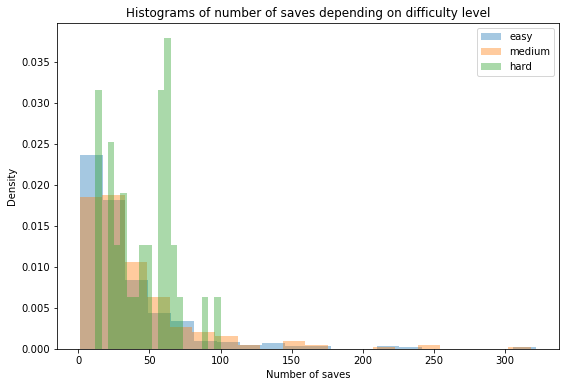

In [50]:
plt.figure(figsize=(9,6))
plt.hist(easy, bins=20, density=True, alpha=0.4, label='easy')
plt.hist(medium, bins=20, density=True, alpha=0.4, label='medium')
plt.hist(hard, bins=20, density=True, alpha=0.4, label='hard')
plt.xlabel('Number of saves')
plt.ylabel('Density')
plt.title('Histograms of number of saves depending on difficulty level')
plt.legend();

In [32]:
print(np.mean(easy), np.median(easy))
print(np.mean(medium), np.median(medium))
print(np.mean(hard), np.median(hard))

33.851351351351354 23.0
38.457142857142856 26.0
45.47222222222222 47.5


In [38]:
hard.shape[0]

36

Судя по графику и выборочным средним, 3 сложность обособлена от других двух и имеет в среднем больше сохранений, хотя на это влияет и число наблюдений в выборках. А вот статистическую значимость разницы между матожиданиями 1 и 2 сложности хотелось бы проверить.

Нулевая гипотеза: МО_сл1 = МО_сл2 <br /> Альтернативная гипотеза: МО_сл1 =/= МО_сл2

По гистограммам видно, что выборки не похожи на нормальные. Нам нужна статистика, которая бы подошла для проверки гипотезы о матожиданиях для выборок не из нормального распределения.

Выполняются предпосылки: независимость выборок, большое число наблюдений. Однако есть выбросы. Поэтому воспользуемся бутстрапом. <br /> *(Нас также интересовала доля этих выбросов, чтобы ответить на вопрос о том, посты какой сложности имеют больший потенциал "выстрелить". Но это уже совсем другая гипотеза)*

In [40]:
def get_bootstrap_sample(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample

In [42]:
def stat_intervals(boot, alpha=0.05):
    left = np.quantile(boot, alpha/2)
    right = np.quantile(boot, 1-alpha/2)
    return left, right

In [41]:
x_boot = get_bootstrap_sample(easy, B_sample=10**4)
x_boot = np.median(x_boot, axis=0)

y_boot = get_bootstrap_sample(medium, B_sample=10**4)
y_boot = np.median(y_boot, axis=0)

In [43]:
stat_intervals(x_boot)

(21.0, 25.0)

In [44]:
stat_intervals(y_boot)

(22.0, 30.0)

In [45]:
stat_intervals(x_boot - y_boot)

(-7.5, 1.0)

In [49]:
np.mean(x_boot - y_boot > 0) # вероятность, что разница будет больше 0

0.0485

Получается, на уровне значимости 5% нет разницы между матожиданием числа сохранений постов 1 сложности и постов 2 сложности

Т.к. у выборки 3 сложности не такое большое количество наблюдений, а распределение вряд ли нормальное, снова воспользуемся бутстрапом

Нулевая гипотеза: МО_сл3 = МО_сл1 (и, соответственно, МО_сл2) <br /> Альтернативная гипотеза: МО_сл3 =/= МО_сл1

In [51]:
z_boot = get_bootstrap_sample(hard, B_sample=10**4)
z_boot = np.median(z_boot, axis=0)

In [52]:
stat_intervals(z_boot)

(30.0, 60.0)

In [55]:
stat_intervals(z_boot - x_boot)

(7.0, 37.5)

In [56]:
np.mean(z_boot - x_boot > 0)

0.9998

Получается, на уровне значимости 5% отвергаем гипотезу о том, что нет разницы между матожиданием числа сохранений постов с 3 сложностью и другими уровнями сложности. Матожидание у 3 сложности больше, чем у других представленных.

Таким образом, уровень сложности влияет на сохранения, но только если это 3й уровень. Между 1 и 2 нет разницы в матожидании сохранений, а вот 3й в среднем собирает больше сохранений. </br> Вот такой вывод делаем из результатов тестирования гипотез с использованием нашей выборки.

### Проверка гипотез 1.2

Попробуем всё-таки проверить гипотезы о долях, чтобы узнать, какая сложность более вероятно может превзойти матожидание, и набрать очень много сохранений, став супер нужной и популярной. Снова понадобится бутстрап по указанным ранее причинам.

Нулевая гипотеза: Д_сл1 = Д_сл2 <br /> Альтернативная гипотеза: Д_сл1 > Д_сл2

In [113]:
def stat_razn_dolei(v1, v2, al):
    greater1 = np.where(v1 > np.mean(v1), 1, 0)
    greater2 = np.where(v2 > np.mean(v2), 1, 0)
    d1 = greater1.mean()
    d2 = greater2.mean()
    razn = d1 - d2
    norm_rv = sts.norm()
    z_crit = norm_rv.ppf(1 - al)
    z_stat = (razn - 0)/np.sqrt((d1*(1 - d1))/len(v1) + (d2*(1 - d2))/len(v2))
    return z_stat, z_crit

In [114]:
x_boot = get_bootstrap_sample(easy, B_sample=10**4)
x_boot = np.median(x_boot, axis=0)

y_boot = get_bootstrap_sample(medium, B_sample=10**4)
y_boot = np.median(y_boot, axis=0)

In [115]:
stat_razn_dolei(easy, medium, 0.05)

(-0.3505965717332036, 1.6448536269514722)

Значение статистики не попадает в область отвержения гипотезы [z_crit; +inf) Поэтому мы не отвергаем нулевую гипотезу. Сложности 1 и 2 одинаково вероятно "выстреливают" согласно нашему суждению.

Нулевая гипотеза: Д_сл2 = Д_сл3 <br /> Альтернативная гипотеза: Д_сл2 > Д_сл3

In [116]:
x_boot = get_bootstrap_sample(easy, B_sample=10**4)
x_boot = np.median(x_boot, axis=0)

z_boot = get_bootstrap_sample(hard, B_sample=10**4)
z_boot = np.median(hard, axis=0)

In [117]:
di_razn_dolei(medium, hard, 0.05)

(-1.7851255072182237, 1.6448536269514722)

Значение статистики не попадает в область отвержения гипотезы [z_crit; +inf) Значит, мы не отвергаем нулевую гипотезу. Сложности 2 и 3 тоже одинаково вероятно могут получить популярность, а точнее, их сохранения одинаково могут быть выше ожидаемых (возможно, при иной гипотезе и более высокой планке популярности мы бы получили иные результаты), а если ещё точнее, при проведении теста не обошлось без допущений, поэтому точнее не выходит(

### Проверка гипотез 2

In [ ]:
longread = df.loc[(df['Время чтения'] > )]['В закладках'].values

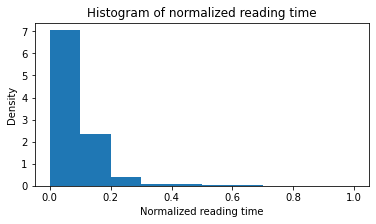

In [128]:
plt.figure(figsize=(6,3))
plt.hist(df.norm_ReadingTime, density=True)
plt.xlabel('Normalized reading time')
plt.ylabel('Density')
plt.title('Histogram of normalized reading time')
plt.show()

Попробуем узнать, есть ли связь между временем чтения и соотношения сохранений к просмотрам. Если пост объемный, больше ли у него в среднем показатель полезности? <br/> Для этого проверим гипотезу о матожиданиях для большого времени чтения и меньшего времени чтения. В качестве разделителя выборки по времени чтения возьмем медиану времени чтения. В целом, получаются почти одинаковые по размеру выборки, поэтому можно попробовать взять именно такое разделение и проверить: лучше больше или меньше.

In [141]:
df.norm_ReadingTime[df.norm_ReadingTime > df.norm_ReadingTime.median()].size, df.norm_ReadingTime[df.norm_ReadingTime <= df.norm_ReadingTime.median()].size

(449, 551)

In [153]:
longread = df[df.norm_ReadingTime > df.norm_ReadingTime.median()]['Savings_per_Views'].values
shortread = df[df.norm_ReadingTime <= df.norm_ReadingTime.median()]['Savings_per_Views'].values

Нулевая гипотеза: МО_длинн = МО_корот <br /> Альтернативная гипотеза: МО_длинн =/= МО_корот

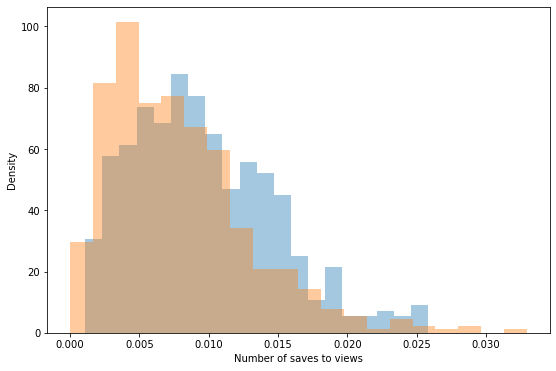

In [154]:
plt.figure(figsize=(9,6))
plt.hist(longread, bins=20, density=True, alpha=0.4, label='longread')
plt.hist(shortread, bins=20, density=True, alpha=0.4, label='shortread')
plt.xlabel('Number of saves to views')
plt.ylabel('Density')
plt.show()

Выборки кажутся распределениями ближе к нормальному, но не факт, а ещё имеют выбросы... Снова используем бутстрап

In [155]:
x_boot = get_bootstrap_sample(longread, B_sample=10**4)
x_boot = np.median(x_boot, axis=0)

y_boot = get_bootstrap_sample(shortread, B_sample=10**4)
y_boot = np.median(y_boot, axis=0)

In [156]:
stat_intervals(x_boot)

(0.0084415584415584, 0.0095)

In [157]:
stat_intervals(y_boot)

(0.0064516129032258, 0.0073333333333333)

In [158]:
stat_intervals(x_boot - y_boot)

(0.0012987012987013009, 0.002777777777777799)

In [159]:
np.mean(x_boot - y_boot > 0) # вероятность, что разница будет больше 0

1.0

Отвергаем нулевую гипотезу о том, что сохранения к просмотрам одинаковы для "лонгридов" и более коротких постов (по нашему определению). Получается, что "лонгриды" имеют больший показатель взаимодействия, судя по нашим данным и тесту.

В итоге, в ходе проверки гипотез мы узнали, что для выборок из наших данных ключевой для проекта показатель сохранений варьируется в зависимости от сложности (при этом, после проверки ещё гипотез не обнаружилось, что какой-то из уровней сложности более склонен вырываться вперед по популярности), а также что более объемные посты имеют большее соотношение сохранений к просмотрам. <br />Выводы о закономерностях в данных тем более основательны, чем более репрезентативна выборка и чем больше мы бы изменяли и пробовали гипотезы (в рамках разумного), однако для обобщения мы попробовали сделать некоторые заключения.